# Needs to run with postmerger enviro

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as pl
from lal._lal import SpinWeightedSphericalHarmonic as sYlm
import postmerger as pm
import random
import qnm
import qnm_filter
sys.path.append('..')

In [177]:
fitname = '3dq8_20M'
fit = pm.load_fit(fitname)

In [178]:
def hlm_total(mass_ratio,chi1z,chi2z,time,l,m,n,iota,phi):
    amp_220 = fit.predict_amp(mass_ratio,chi1z,chi2z,(2,2),(2,2,0),return_std=False,start_time=time)
    phase_220 = fit.predict_phase(mass_ratio,chi1z,chi2z,(2,2),(2,2,0),return_std=False,start_time=time)

    #print('absolute amplitude 220:\t  %.3f' % amp_220)
    #print('absolute phase 220:\t  %.3f' % phi_220)
    
    rel_amp = fit.predict_amp(mass_ratio,chi1z,chi2z,(l,m),(l,m,n),return_std=False,start_time=time)
    rel_phase = fit.predict_phase(mass_ratio,chi1z,chi2z,(l,m),(l,m,n),return_std=False,start_time=time)
    
    if l==2 and m==2 and n==0:
        amp = amp_220
        phase = phase_220
    
    else:  
        amp = rel_amp * amp_220
        phase = rel_phase + m/2*phase_220

    hlm = amp * np.exp(-1j*phase)
    hl_m = (-1)**l * np.conjugate(hlm)
    hlm_total = hlm*sYlm(iota,phi,-2,l,m) + hl_m*sYlm(iota,phi,-2,l,-1*m)
    return(np.abs(hlm_total), phase)

def power_calc(omega, tau, amp, phi):
    temp0 = amp**2*tau*(1+tau**2+omega**2+np.cos(2*phi)-tau*omega*np.sin(2*phi))
    temp1 = 4+4*tau**2*omega**2
    return temp0/temp1

In [179]:
mass1 = random.uniform(30, 70)
mass2 = random.uniform(20, mass1)
mass_ratio = mass1/mass2 # defined to be >=1
chi1z = random.uniform(0, 0.8)
chi2z = random.uniform(0, 0.8)
start_time = 0

# no need for final mass/spin, this is just for own reference
massf = pm.final_mass(mass1,mass2,chi1z,chi2z,aligned_spins=True)
chifz, thetaf = pm.final_spin(mass1,mass2,chi1z,chi2z,aligned_spins=True,return_angle=True)

print('final mass:',massf)
print('final spin:',chifz)
print('final orientation:',np.cos(thetaf))

iota = random.uniform(0, 2*np.pi)
phi = random.uniform(0, 2*np.pi)

final mass: 64.5422442677085
final spin: 0.6535863161242206
final orientation: 1.0


In [180]:
amp_dict = {}
phase_dict = {}
for key in fit.modes.keys():
    for mode in fit.modes[key]:
        if len(mode) == 3:
            l, m, n = mode
            amp, phase = hlm_total(mass_ratio,chi1z,chi2z,start_time,l,m,n,iota,phi)
            amp_dict[mode] = amp
            phase_dict[mode] = phase
fundamental_modes = {key: value for key, value in amp_dict.items() if key[2] == 0}
sorted_fundamentals = sorted(fundamental_modes.items(), key=lambda x: x[1], reverse=True)
sorted_modes = sorted(amp_dict.items(), key=lambda x: x[1], reverse=True)

In [181]:
sampling_frequency = 4096
duration = 4  # in second
time_arr = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
mass_unit = qnm_filter.Filter.mass_unit(massf)
time_offset = 3

input = dict(model_list=[(2,2,0,'p')],
             t_init=time_offset*mass_unit, #Not geocentric but L1 so no sky location added
             segment_length=0.2,
             srate=4096,
             ra=None, dec=None, 
             flow=20,
             trim = 0.05)

In [182]:
signal_dict = {}
for i in sorted_fundamentals[:3]:
    (l, m, n), amp = i
    omega = qnm.modes_cache(s=-2,l=l,m=m,n=n)(a=chifz)[0]
    phi = phase_dict[(l, m, n)]
    signal = np.real(amp * np.exp(-1j * (omega * np.abs(time_arr / mass_unit) + phi)))
    signal_dict[(l,m,n)] = signal
    print("Mode=(%d,%d,%d),amp=%.3g,phase=%.3g"%(l,m,n,amp,phi))
    f = np.real(omega)
    tau = -1/np.imag(omega)
    power = power_calc(f, tau, amp, phi)
    print("Power=%.2f" % power)

Mode=(2,2,0),amp=0.267,phase=1.9
Power=0.82
Mode=(3,3,0),amp=0.084,phase=2.46
Power=0.03
Mode=(2,1,0),amp=0.0652,phase=-2.17
Power=0.06


In [183]:
mmax = 10e-21 
NR_signal = np.zeros(len(signal))
for key, item in signal_dict.items():
    NR_signal += mmax*item
    
ifo_H1 = qnm_filter.set_bilby_predefined_ifo(
"H1", sampling_frequency, duration, start_time=-duration / 2
)
signalH_noise = qnm_filter.bilby_get_strain(ifo_H1, 0.0)
ifo_L1 = qnm_filter.set_bilby_predefined_ifo(
"L1", sampling_frequency, duration, start_time=-duration / 2
)
signalL_noise = qnm_filter.bilby_get_strain(ifo_L1, 0.0)

In [185]:
fit = qnm_filter.Network(**input)
fit.original_data = {}
fit.original_data['H1'] = qnm_filter.RealData(NR_signal, index=time_arr)
fit.original_data['L1'] = qnm_filter.RealData(NR_signal, index=time_arr)
fit.detector_alignment()
fit.condition_data('original_data', **input)

fit.pure_noise = {}
fit.pure_noise["H1"] = qnm_filter.RealData(signalH_noise, index=time_arr)
fit.pure_noise["L1"] = qnm_filter.RealData(signalL_noise, index=time_arr)
fit.condition_data('pure_noise', **input)
fit.compute_acfs('pure_noise')
fit.cholesky_decomposition()
fit.first_index()

fit.pure_nr = {}
fit.pure_nr['H1'] = qnm_filter.RealData(NR_signal, index=time_arr)
fit.condition_data('pure_nr', **input)
SNR = fit.compute_SNR(None, fit.truncate_data(fit.pure_nr)['H1'], 'H1', True)
print(SNR)

fit.pure_nr = {}
fit.pure_nr['H1'] = qnm_filter.RealData(mmax*signal_dict[(2,2,0)], index=time_arr)
fit.condition_data('pure_nr', **input)
SNR = fit.compute_SNR(None, fit.truncate_data(fit.pure_nr)['H1'], 'H1', True)
print(SNR)

fit.pure_nr = {}
fit.pure_nr['H1'] = qnm_filter.RealData(mmax*signal_dict[(3,3,0)], index=time_arr)
fit.condition_data('pure_nr', **input)
SNR = fit.compute_SNR(None, fit.truncate_data(fit.pure_nr)['H1'], 'H1', True)
print(SNR)

fit.pure_nr = {}
fit.pure_nr['H1'] = qnm_filter.RealData(mmax*signal_dict[(2,1,0)], index=time_arr)
fit.condition_data('pure_nr', **input)
SNR = fit.compute_SNR(None, fit.truncate_data(fit.pure_nr)['H1'], 'H1', True)
print(SNR)

31.067484588155267
31.848976219395595
10.018268875710103
7.519880375837055


In [163]:
def analysis():
    fit = qnm_filter.Network(**input)
    fit.original_data = {}
    fit.original_data['H1'] = qnm_filter.RealData(NR_signal, index=time_arr)
    fit.original_data['L1'] = qnm_filter.RealData(NR_signal, index=time_arr)
    fit.detector_alignment()
    fit.condition_data('original_data', **input)

    fit.pure_noise = {}
    fit.pure_noise["H1"] = qnm_filter.RealData(signalH_noise, index=time_arr)
    fit.pure_noise["L1"] = qnm_filter.RealData(signalL_noise, index=time_arr)
    fit.condition_data('pure_noise', **input)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()

    fit.pure_nr = {}
    fit.pure_nr['H1'] = qnm_filter.RealData(NR_signal, index=time_arr)
    fit.pure_nr['L1'] = qnm_filter.RealData(NR_signal, index=time_arr)
    fit.condition_data('pure_nr')
    SNR = fit.compute_SNR(fit.truncate_data(fit.original_data)['H1'], fit.truncate_data(fit.pure_nr)['H1'], 'H1', False)

    likelihood_data, evidence = qnm_filter.parallel_compute(
        fit, massspace, chispace, num_cpu=8, **input)
    credible_region = qnm_filter.find_credible_region(likelihood_data)

In [6]:
def signal_creator():
    global signal, signal220, signal330, signal440, time_arr, signalH_noise, signalL_noise
    injected = (random.uniform(40, 80), 0.7)
    mass = qnm_filter.Filter.mass_unit(injected[0])
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega330 = qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=injected[1])[0]
    omega440 = qnm.modes_cache(s=-2,l=4,m=4,n=0)(a=injected[1])[0]

    mmax = 0.8 * 1e-21 
    phase220 = random.uniform(0, 2*np.pi)
    A220x = mmax*np.cos(phase220)
    A220y = mmax*np.sin(phase220)
#     phase330 = 0
#     A330x = mmax*np.cos(phase330)
#     A330y = mmax*np.sin(phase330)
#     phase440 = 0
#     A440x = mmax*np.cos(phase440)
#     A440y = mmax*np.sin(phase440)

    amp220 = 1.2
#     amp330 = 1.2
#     amp440 = 0.7

    sampling_frequency = 4096 * 1  # in Hz
    duration = 2  # in second
    time_arr = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real(amp220 * (A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(time_arr / mass)))
#     signal330 = np.real(amp330 * (A330x + 1j * A330y) * np.exp(-1j * omega330 * np.abs(time_arr / mass)))
#     signal440 = np.real(amp440 * (A440x + 1j * A440y) * np.exp(-1j * omega440 * np.abs(time_arr / mass)))

    #CN section
    ifo_H1 = qnm_filter.set_bilby_predefined_ifo(
    "H1", sampling_frequency, duration, start_time=-duration / 2
    )
    signalH_noise = qnm_filter.bilby_get_strain(ifo_H1, 0.0)
    ifo_L1 = qnm_filter.set_bilby_predefined_ifo(
    "L1", sampling_frequency, duration, start_time=-duration / 2
    )
    signalL_noise = qnm_filter.bilby_get_strain(ifo_L1, 0.0)

[((2, 2, 1), array([1.91987337])),
 ((2, 1, 1), array([0.13055975])),
 ((3, 3, 1), array([0.10185147])),
 ((4, 4, 1), array([0.09422218])),
 ((2, 2, 0), array([0.05062785])),
 ((4, 3, 1), array([0.04087902])),
 ((4, 4, 0), array([0.02306018])),
 ((3, 2, 1), array([0.02009901])),
 ((2, 1, 0), array([0.01461067])),
 ((3, 2, 0), array([0.00829135])),
 ((5, 5, 1), array([0.00581987])),
 ((3, 3, 0), array([0.00273008])),
 ((4, 3, 0), array([0.0013552])),
 ((5, 5, 0), array([0.00051512]))]

In [7]:
2/0.05

40.0

In [19]:
omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=chifz)[0]
f220 = np.real(omega220)
tau220 = -1/np.imag(omega220)

In [39]:
props220 = hlm_total(mass_ratio,chi1z,chi2z,start_time,2,2,0,iota,phi)
power_calc(f220, tau220, props220[0][0], props220[1][0])

0.01796321453499604

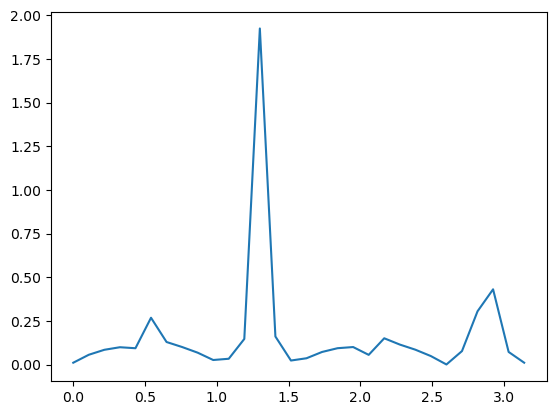

In [46]:
start_time = 0
ratio = []
iota = np.pi/2
phi_space = np.linspace(0, np.pi, 30)
for i in iota_space:
    temp0 = hlm_total(mass_ratio,chi1z,chi2z,start_time,2,2,0,iota,i)
    temp1 = hlm_total(mass_ratio,chi1z,chi2z,start_time,3,3,0,iota,i)
    actual_amp0 = temp0[0]*np.cos(temp0[1])
    actual_amp1 = temp1[0]*np.cos(temp1[1])
    ratio.append(abs(actual_amp1/actual_amp0))
    
pl.plot(phi_space, ratio)

In [14]:
mass1 = 167.4
mass2 = 78.36
mass_ratio = mass1/mass2 # defined to be >=1
chi1z = 0.723
chi2z = 0.553
start_time = 0
amp_dict = {}
for key in fit.modes.keys():
    for mode in fit.modes[key]:
        if len(mode) == 3:
            l, m, n = mode
            amp, phase = hlm_total(mass_ratio,chi1z,chi2z,start_time,l,m,n,iota,phi)
            amp_dict[mode] = amp
sorted(amp_dict.items(), key=lambda x: x[1], reverse=True)

[((3, 3, 1), array([1.07329458])),
 ((4, 4, 1), array([0.29260432])),
 ((2, 2, 0), array([0.25504311])),
 ((5, 5, 1), array([0.16120442])),
 ((3, 2, 1), array([0.15473598])),
 ((3, 3, 0), array([0.10258218])),
 ((2, 1, 1), array([0.04221217])),
 ((2, 2, 1), array([0.03943947])),
 ((4, 3, 1), array([0.02129792])),
 ((2, 1, 0), array([0.01658772])),
 ((4, 4, 0), array([0.01444435])),
 ((3, 2, 0), array([0.00272711])),
 ((5, 5, 0), array([0.00198039])),
 ((4, 3, 0), array([0.00025462]))]